In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [80]:
class NN(nn.Module):
    def __init__(self,input_size,num_classes):
        super(NN, self).__init__()
        self.fc1=nn.Linear(input_size,50)
        self.fc2=nn.Linear(50,num_classes)

    def forward(self,x):
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x




In [81]:
class CNN(nn.Module):
    def __init__(self,in_channels=1,num_classes=10):
        super(CNN, self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.pool=nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.fc1=nn.Linear(16*7*7,num_classes)


    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=self.pool(x)
        x=F.relu(self.conv2(x))
        x=self.pool(x)
        x=x.reshape(x.shape[0],-1)
        x=self.fc1(x)
        return x

In [82]:
model=CNN()
x=torch.randn(64,1,28,28)
print(x.shape)
print(model(x).shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 10])


Checking acc on train data
Got 58192 / 60000 with accuracy 96.99
Check acc on test data
Got 9731 / 10000 with accuracy 97.31
Checking acc on train data
Got 58824 / 60000 with accuracy 98.04
Check acc on test data
Got 9803 / 10000 with accuracy 98.03
Checking acc on train data
Got 58925 / 60000 with accuracy 98.21
Check acc on test data
Got 9808 / 10000 with accuracy 98.08


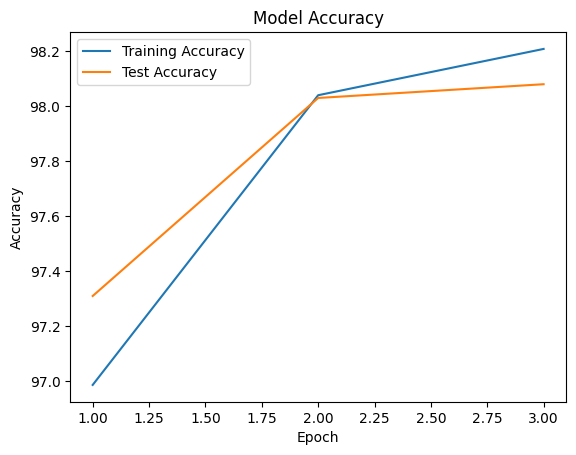

In [88]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

in_channels=1
num_classes=10
learning_rate=0.001
batch_size=64
num_epochs=3

transforms_train=transforms.Compose([transforms.ToTensor()])


#load Data
train_dataset=datasets.MNIST(root='dataset/',train=True,transform=transforms_train,download=True)
train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True )

test_dataset=datasets.MNIST(root='dataset/',train=False,transform=transforms_train,download=True)
test_loader=DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True )



#Initialize network
model=CNN().to(device=device)

##Loss And Optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)


#Train network

def train_model(num_epochs, model, train_loader, test_loader, optimizer, criterion):
    train_accuracy = []
    test_accuracy = []

    for epoch in range(num_epochs):
        for batch_idx,(data,targets) in enumerate(train_loader):
            #Get data to cuda if possible
            data=data.to(device=device)
            targets=targets.to(device=device)

            #Get to correct shape
            # data=data.reshape(data.shape[0],-1)
          

            #Forward
            scores=model(data)
            loss=criterion(scores,targets)

            #Backward
            optimizer.zero_grad()
            loss.backward()

            #Gradient descent or adam step
            optimizer.step()

        train_acc = check_accuracy(train_loader, model)
        test_acc = check_accuracy(test_loader, model)
        
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
        
    return train_accuracy, test_accuracy

#Check accuracy on training § test our model

def check_accuracy(loader,model):
    if loader.dataset.train:
        print('Checking acc on train data')
    else:
        print('Check acc on test data')
    num_correct=0
    num_samples=0
    model.eval()

    with torch.no_grad():
        for x,y in loader:
            x=x.to(device=device)
            y=y.to(device=device)
            # x=x.reshape(x.shape[0],-1)

            scores=model(x)
            _,prediction=scores.max(1)
            num_correct+=(prediction==y).sum()
            num_samples+=prediction.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

    model.train()
    accuracy = float(num_correct) / float(num_samples) * 100
    return accuracy


def plot_accuracy(train_accuracy, test_accuracy):
    epochs = range(1, len(train_accuracy) + 1)

    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, test_accuracy, label='Test Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

train_accuracy, test_accuracy = train_model(num_epochs, model, train_loader, test_loader, optimizer, criterion)
plot_accuracy(train_accuracy, test_accuracy)

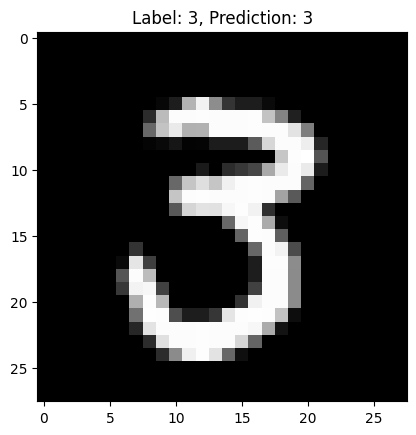

In [ ]:
import random 

def select_random_image(loader):
    # Veri yükleyicisinden rastgele bir batch seç
    data_iter = iter(loader)
    images, labels = data_iter.__next__()
    
    # Rastgele bir örnek seç
    index = random.randint(0, len(images) - 1)
    image = images[index]
    label = labels[index]
    
    return image, label

def predict_image(model, image):
    # Modeli değerlendirme moduna geçir
    model.eval()
    
    # Görüntüyü modele ileterek tahmin yap
    with torch.no_grad():
        # Görüntüyü düzleştir
        image = image.view(1, -1)
        
        # Tahmini hesapla
        output = model(image)
        _, predicted = torch.max(output, 1)
        
    return predicted.item()

def show_image_with_prediction(image, label, prediction):
    # Görüntüyü ve tahmini ekrana bas
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Label: {label}, Prediction: {prediction}")
    plt.show()

# Örnek kullanım
random_image, true_label = select_random_image(test_loader)
predicted_label = predict_image(model, random_image)
show_image_with_prediction(random_image, true_label, predicted_label)
